In [2]:
import json
import time
import re
from typing import TypedDict, Annotated
from types import SimpleNamespace

import requests
import pandas as pd
from rdflib.plugins.sparql.parser import parseQuery
from rdflib import Graph

from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from openai import AzureOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# ------------------------- GLOBAL STORE -------------------------
GLOBAL_STORE = {}

# ------------------------- TYPED STATE -------------------------
class MyState(TypedDict):
    """
    TypedDict for the state of the application.
    """
    messages: Annotated[list, add_messages]
    rdf_file_path: str
    jsonld_file_path: str
    generated_sparql: str
    sparql_result: str
    final_answer: str



In [3]:
def load_config():
    try:
        with open(r"config.json") as f:
            return json.load(f, object_hook=lambda d: SimpleNamespace(**d))
    except FileNotFoundError:
        raise FileNotFoundError("Config file not found. Please check the path.")


def initialize_azure_client(config):
    client = SecretClient(vault_url=config.key_vault_url, credential=DefaultAzureCredential())
    secret = client.get_secret(config.dev_secret_name)
    return AzureOpenAI(
        api_key=secret.value,
        api_version=config.chat.api_version,
        azure_endpoint=config.chat.azure_endpoint
    )


def query_blazegraph(sparql_query: str, blazegraph_url: str):
    """
    Execute the SPARQL query on Blazegraph, returning JSON results.
    """
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(blazegraph_url, params={'query': sparql_query}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"SPARQL query failed with status {response.status_code} - {response.text}")



In [4]:
def init_node(state: MyState):
    """
    1) Load the config
    2) Initialize AzureOpenAI client
    3) Store them in GLOBAL_STORE
    """
    config = load_config()
    llm_client = initialize_azure_client(config)

    # Define the Blazegraph URL
    blazegraph_url = "http://localhost:9999/blazegraph/namespace/fin/sparql"

    GLOBAL_STORE["config"] = config
    GLOBAL_STORE["llm"] = llm_client
    GLOBAL_STORE["blazegraph_url"] = blazegraph_url

    return {
        "messages": state["messages"]
        }  


In [5]:
def upload_rdf_node(state: MyState):
    """
    Upload an RDF file to Blazegraph
    """
    rdf_file_path = state["rdf_file_path"]
    blazegraph_url = GLOBAL_STORE["blazegraph_url"]

    with open(rdf_file_path, 'r', encoding='utf-8') as rdf_file:
        rdf_data = rdf_file.read()

    headers = {'Content-Type': 'application/x-turtle'}
    response = requests.post(blazegraph_url + "/update", data=rdf_data, headers=headers)
    if response.status_code == 200:
        print("RDF data successfully uploaded to Blazegraph.")
    else:
        print(f"Failed to upload RDF data. Status code: {response.status_code}")
        print(response.text)

    return {
        "rdf_file_path": state["rdf_file_path"]
    }


In [6]:
def process_jsonld_node(state: MyState):
    """
    Reads a JSON-LD file, extracts prefixes, classes, properties,
    and stores them in GLOBAL_STORE for generating the prompt.
    """
    file_path = state["jsonld_file_path"]
    with open(file_path, 'r', encoding='utf-8') as file:
        jsonld_data = json.load(file)

    context = jsonld_data.get("@context", {})
    graph = jsonld_data.get("@graph", [])

    prefixes = {key: value for key, value in context.items()}
    classes = [g for g in graph if g.get("@type") == "rdfs:Class"]
    properties = [g for g in graph if g.get("@type") == "rdf:Property"]

    # Format them if you like, or store raw
    GLOBAL_STORE["jsonld_prefixes"] = prefixes
    GLOBAL_STORE["jsonld_classes"] = classes
    GLOBAL_STORE["jsonld_properties"] = properties

    return {
        "jsonld_file_path": state["jsonld_file_path"]
    }


In [8]:
def prepare_prompt_node(state: MyState):
    """
    Create the big prompt string from the JSON-LD data 
    (prefixes, classes, properties) for use by the LLM.
    Store it in GLOBAL_STORE.
    """
    prefixes = GLOBAL_STORE["jsonld_prefixes"]
    classes = GLOBAL_STORE["jsonld_classes"]
    properties = GLOBAL_STORE["jsonld_properties"]

    # Format prefixes
    formatted_prefixes = "\n".join([f"{k}: <{v}>" for k, v in prefixes.items()])
    # Format classes
    formatted_classes = "\n".join([
        f"- ID: {c.get('@id')}, Label: {c.get('label','No label')}, Description: {c.get('description','No desc')}"
        for c in classes
    ])
    # Format properties
    formatted_properties = "\n".join([
        f"- ID: {p.get('@id')}, Label: {p.get('label','No label')}, Description: {p.get('description','No desc')}"
        for p in properties
    ])

    big_prompt = f"""
    ### Prefixes
    {formatted_prefixes}

    ### Classes
    {formatted_classes}

    ### Properties
    {formatted_properties}

    ### **Query Mapping Rules**
    - **People Queries:** Use 'Schema:givenName', 'Schema:familyName', 'Schema:email', 'Schema:gid', 'Schema:jobTitle', 'fin:manages', 'Schema:hasManager', 'pro:manages'.
    - **Organization Queries:** Use 'Schema:name', 'Schema:hasHead', 'Schema:hasChildOrganization', 'Schema:parentOrganization', 'Schema:worksFor'.
    - **Application Queries:** Use 'app:appName' for exact application names, 'app:accessLink', 'app:managedBy', 'app:hasOwner', 'app:partofOrg', 'app:appDescription' for descriptions, 'pro:partOfOrg' .
    - **Process Queries:** Use 'pro:title', 'pro:description', 'pro:managedBy', 'pro:hasChildProcess', 'pro:hasApplication', 'pro:hasOwner'.
    
    ### **Output Rules**
    - ALWAYS include 'schema:givenName' and 'schema:familyName' for 'Person' data and 'schema:name' for 'Organisation' data.
    - Ensure case-insensitive matching for 'schema:name' and 'schema:description' properties.
    - Ensure case-insensitive matching for 'app:appDescription' property using FILTER regex.
    - Use 'OPTIONAL' for the 'schema:sources' property al.
    - Output only the SPARQL query without any additional text.
    
    ### **Examples SPARQL Queries**
 
        **Example 1: List people located in specific location**
        ```
        PREFIX schema: <https://schema.org/>
        SELECT ?givenName ?familyName ?email ?gid ?jobTitle ?sources
        WHERE {{
            ?person a schema:Person ;
                    schema:location "DXB G" ;
                    schema:givenName ?givenName ;
                    schema:familyName ?familyName ;
                    schema:email ?email ;
                    schema:gid ?gid ;
                    schema:jobTitle ?jobTitle .
            OPTIONAL {{ ?person schema:sources ?sources . }}
  
        }}        
        ```
 
        **Example 2: Retrieve the head of a specific organization**
        
        PREFIX schema: <https://schema.org/>
        SELECT ?givenName ?familyName ?email ?sources
        WHERE {{
            ?organization a schema:Organization ;
                          schema:name "Martin-Bishop" ;
                          schema:hasHead ?head .
            ?head schema:givenName ?givenName ;
                  schema:familyName ?familyName ;
                  schema:sources ?sources;
                  schema:email ?email .
            OPTIONAL {{ ?head schema:sources ?sources . }}
            OPTIONAL {{ ?organization schema:sources ?sources . }}
        }}
     
 
        **Example 3: Count the number of employees in an organization**
       
        PREFIX schema: <https://schema.org/>
        SELECT (COUNT(?employee) AS ?employeeCount) 
        WHERE {{
            ?employee a schema:Person ;
                      schema:worksFor ?organization .
            ?organization schema:name "Martin-Bishop" .
            OPTIONAL {{ ?employee schema:sources ?sources . }}
            OPTIONAL {{ ?organization schema:sources ?sources . }}
        }}
        
        
        **Example 4: Retrieve the applications managed by a specific person** 
        PREFIX app: <http://application.com/>
        PREFIX schema: <https://schema.org/>

        SELECT ?appName ?accessLink ?sources
        WHERE {{
            ?manager a schema:Person ;
                    schema:givenName ""Lori"" ;
                    schema:familyName ""Bennett"" .
            ?application a app:Application ;
                        app:managedBy ?manager ;
                        app:appName ?appName ;
                        app:accessLink ?accessLink ;
                        app:isDeleted false .
            OPTIONAL {{ ?application schema:sources ?sources . }}
        }}

            
        
        **Example 5: List all applications owned by a specific employee** 
      
        PREFIX app: <http://application.com/>
        PREFIX schema: <https://schema.org/>

        SELECT ?appName ?accessLink ?sources
        WHERE {{
            ?owner a schema:Person ;
                    schema:givenName ""Lori"" ;
                    schema:familyName ""Bennett"" .
            ?application a app:Application ;
                        app:hasOwner ?owner ;
                        app:appName ?appName ;
                        app:accessLink ?accessLink ;
                        app:isDeleted false .
            OPTIONAL {{ ?application schema:sources ?sources . }}
        }} 
            
        
        **Example 6: Retrieve applications under a specific organization** 
        
        
        PREFIX app: <http://application.com/> 
        PREFIX schema: <https://schema.org/> 
        SELECT ?appName ?accessLink ?sources
        WHERE {{     
            ?application a app:Application ;                  
            app:appName ?appName ;                  
            app:accessLink ?accessLink ;                  
            app:worksForOrg ?organization .     
            
            ?organization schema:name "Martin-Bishop" . 
            OPTIONAL {{ ?application schema:sources ?sources . }}
            OPTIONAL {{ ?organization schema:sources ?sources . }}
            }} 
            
        
        **Example 7: Retrieve applications under a parent organization** 

        
        PREFIX app: <http://application.com/> 
        PREFIX schema: <https://schema.org/> 
        SELECT ?appName ?accessLink ?sources
        WHERE {{     
            ?application a app:Application ;                  
            app:appName ?appName ;                  
            app:accessLink ?accessLink ;                  
            app:worksForOrg ?organization .     
            ?organization schema:parentOrganization ?parentOrg .     
            ?parentOrg schema:name "Mooney, Marshall and Parker" . 
            OPTIONAL {{ ?application schema:sources ?sources . }}
            OPTIONAL {{ ?organization schema:sources ?sources . }}
            }}
        
        **Example 8: Retrieve applications managed by a specific person's team members**
        PREFIX app: <http://application.com/>
        PREFIX schema: <https://schema.org/>
        SELECT ?appName ?accessLink ?name ?sources
        WHERE {{
            ?employee a schema:Person ;
                    schema:givenName ""Lori"" ;
                    schema:familyName ""Bennett"" .
                    schema:worksFor ?organization .
            ?teamMember a schema:Person ;
                        schema:name ?name ;
                        schema:worksFor ?organization .
                        
            ?application a app:Application ;
                        app:managedBy ?teamMember ;
                        app:appName ?appName ;
                        app:accessLink ?accessLink .
            OPTIONAL {{ ?application schema:sources ?sources . }}
            OPTIONAL {{ ?teamMember schema:sources ?sources . }}
        }}
        
        
        **Example 9: Retrieve the manager of an employee**
        PREFIX schema: <https://schema.org/>
 
        SELECT ?lineManagerName ?sources
        WHERE {{
        ?person schema:givenName "Billy" ;
                schema:familyName "Bryan" ;
                schema:hasManager ?manager .
        ?manager schema:givenName ?managerGivenName ;
                schema:familyName ?managerFamilyName .
        BIND(CONCAT(?managerGivenName, " ", ?managerFamilyName) AS ?lineManagerName)
        OPTIONAL {{ ?manager schema:sources ?sources . }}
        }}
        
        **Example 10: Retrieve people reporting to a person**
        PREFIX schema: <https://schema.org/>
  
        SELECT ?reporteeName ?email ?sources
        WHERE {{
        ?manager schema:givenName "Billy" ;
                schema:familyName "Bryan" ,
        ?reportee schema:hasManager ?manager ;
                    schema:givenName ?reporteeGivenName ;
                    schema:familyName ?reporteeFamilyName ;
                    schema:email ?email .
        OPTIONAL {{ ?reportee schema:sources ?sources . }}
        BIND(CONCAT(?reporteeGivenName, " ", ?reporteeFamilyName) AS ?reporteeName)
        }}

        PREFIX schema: <https://schema.org/>
        PREFIX fin: <http://financial.com/> 
        
        SELECT ?reporteeName ?email ?sources
        WHERE {{
        ?manager schema:givenName "Billy" ;
                schema:familyName "Bryan" ,
                fin:manages ?reportee.
        ?reportee schema:givenName ?reporteeGivenName ;
                    schema:familyName ?reporteeFamilyName ;
                    schema:email ?email .
        OPTIONAL {{ ?reportee schema:sources ?sources . }}
        BIND(CONCAT(?reporteeGivenName, " ", ?reporteeFamilyName) AS ?reporteeName)
        }}

        **Example 11:  Which application gives an overview/description of the Actuals in the System?  **
        PREFIX app: <http://application.com/>
        PREFIX schema: <https://schema.org/>
        SELECT ?appName ?accessLink ?sources
        WHERE {{
            ?application a app:Application ;
                        app:appName ?appName ;
                        app:accessLink ?accessLink ;
                        app:appDescription ?description .
            FILTER (
            regex(?description, "Actuals in the system", 'i') &&
            regex(?description, "Actuals", 'i')
            )
            OPTIONAL {{  ?application schema:sources ?sources . }}
        }}
        
        **Example 12: Retrieve applications managed by a specific person**
        PREFIX app: <http://application.com/>
        PREFIX schema: <https://schema.org/>
        SELECT ?appName ?accessLink ?sources
        WHERE {{
            ?manager a schema:Person ;
                    schema:givenName ""Lori"" ;
                    schema:familyName ""Bennett"" .
            ?application a app:Application ;
                        app:managedBy ?manager ;
                        app:appName ?appName ;
                        app:accessLink ?accessLink .
            OPTIONAL {{ ?application schema:sources ?sources . }}
        }}
        
        **Retrieve processes where the process decription contains Project reporting actuals and FC**
        PREFIX pro: <http://process.com/>
        PREFIX schema: <https://schema.org/>

        SELECT ?proName ?sources
        WHERE {{
            ?process a pro:Process ;
                        pro:title ?proName ;
                        pro:description ?description .
            FILTER (
                regex(?description, "Project", 'i') &&
                regex(?description, "Reporting", 'i') &&
                regex(?description, "Actuals", 'i') &&
                regex(?description, "FC", 'i')
            )
            OPTIONAL {{ ?process schema:sources ?sources . }}
        }}
        
        **Retrieve processes managed by a specific person**
        PREFIX pro: <http://process.com/>
        PREFIX schema: <https://schema.org/>
        SELECT ?proName ?sources
        WHERE {{
            ?manager a schema:Person ;
                    schema:givenName ""Lori"" ;
                    schema:familyName ""Bennett"" .
            ?process a pro:Process ;
                        pro:managedBy ?manager ;
                        pro:title ?proName .
            OPTIONAL {{ ?process schema:sources ?sources . }}
        }}
        **Retrieve description of the process 'Order Backlog'**
        PREFIX pro: <http://process.com/>
        PREFIX schema: <https://schema.org/>
        SELECT ?proDescription ?sources
        WHERE {{   
            ?process a pro:Process ;
                    pro:title "Order Backlog" ;
                    pro:description ?proDescription .
            OPTIONAL {{ ?process schema:sources ?sources . }}
        }}
    """ 

    GLOBAL_STORE["jsonld_prompt"] = big_prompt.strip()
    return {
        "generated_sparql": state["generated_sparql"]
    }



In [9]:
def generate_sparql_node(state: MyState):

    user_query = state["messages"][-1].content
    big_prompt = GLOBAL_STORE.get("jsonld_prompt", "")
    llm = GLOBAL_STORE["llm"]

    messages = [
        {
        "role": "system",
        "content": f"""
        You are a SPARQL query expert that converts natural language queries into SPARQL queries for a specific RDF knowledge graph schema based on the ontology schema.
        Your task is to generate SPARQL queries that strictly adhere to the given schema and use the correct prefixes, classes, and properties.

        The ontology schema delimited by triple backticks is:
        
        ** Ontology Schema:**
        ```
        {big_prompt}


        ### Task
        - Generate SPARQL queries strictly adhering to the schema above.
        - Use only properties and classes defined in the schema, Do NOT create or infer new prefixes or namespaces
        - For applications:
        - Identify if the query refers to `app:appName` or `app:appDescription`.
        - Use `app:hasOwner` for owner retrieval, linked to `schema:Person`.
        - Match `app:appDescription` using case-insensitive `FILTER regex(..., "i")` for each keyword.
        - Use `OPTIONAL` for `?sources`.

        - For processes:
        - Use `pro:title` and `pro:description`.
        - Use `pro:hasOwner` for owners, linked to `schema:Person`.

        - For employees:
        - Retrieve `schema:givenName`, `schema:familyName`, `schema:email`, and `schema:jobTitle`.

        - For organizational structure:
        - Use `schema:parentOrganization` and `schema:hasChildOrganization` (never alternatives like `fin:parentOrganization`).
        - Use `schema:description` when the org name contains natural language .
        - Use `schema:name` for acronyms or short labels.

        - Query construction:
        - Extract keywords from the input and apply individual `FILTER regex(..., "i")` conditions combined with `&&`.
        - If querying process name, use `FILTER regex(?appName, "...", "i")`.
        - If querying description, use `FILTER regex(?appDescription, "...", "i")`.

        - Return only the SPARQL query. Do not include any explanation, comments, or backticks.

        Example input: "Which applications are used in the AR, Overdues community?"  
        → Match `app:appDescription` with keywords `["AR", "Overdues", "community"]`.
        
        Do not include explanations or apologies in your responses. 
        Do NOT wrap the query in backticks.
        Do NOT include any text except the SPARQL query generated. 
        """
    },
    {
        "role": "user",
        "content": f"""
        {user_query}
        """
    }
]
    try:
        start_time = time.time()
        response = llm.chat.completions.create(
            model=GLOBAL_STORE["config"].chat.model,
            messages=messages
            )
        sparql_query = response.choices[0].message.content.strip()
        end_time = time.time()
    except Exception as e:
        error_msg = str(e)
        # Check for the specific error message regarding prompt length.
        if "string too long" in error_msg:
            # Handle the error by returning a clear message.
            return {"generated_sparql": "Error: Prompt exceeds maximum allowed length. Please reduce prompt size."}
        else:
            raise

        # Append LIMIT 15 if no LIMIT clause is already present 
    if "limit" not in sparql_query.lower():
        sparql_query += "\nLIMIT 15"
    return {"generated_sparql": sparql_query}



In [10]:
def check_sparql_validity_node(state: MyState):
   
   generate_sparql = state["generated_sparql"]
   if "```" in generate_sparql:
      print("SPARQL query contains backticks (```), which is not allowed.")
      return "invalid"

   print(f"SPARQL passed validation checks.")

   # Return it in the state
   return "valid"


In [11]:
def handle_sparql_error_node(state: MyState):
    """
    Handle errors due to context length exceeded.
    Regenerate the SPARQL query and ensure it ends with 'LIMIT 15'.
    """
    # Regenerate the SPARQL query
    new_state = generate_sparql_node(state)
    new_query = new_state.get("generated_sparql", "")
 
    # If the error persists, return a clear error message.
    if "Error:" in new_query:
        return {
            "sparql_result": new_query,
            "final_answer": "SPARQL generation failed due to context length constraints. Please reduce prompt size."
        }
 
    # Append LIMIT 15 if not already present (case-insensitive check)
    if "limit" not in new_query.lower():
        new_query += "\nLIMIT 15"
 
    state["generated_sparql"] = new_query
    return state


In [12]:
def run_sparql_node(state: MyState):
    """
    Use the generated SPARQL to query Blazegraph. 
    Store the results as a string in state["sparql_result"].
    """
    sparql_query = state["generated_sparql"]
    blazegraph_url = GLOBAL_STORE["blazegraph_url"]

    start_time = time.time()
    try:
        results_json = query_blazegraph(sparql_query, blazegraph_url)
        end_time = time.time()
        execution_time = end_time - start_time

        if results_json and results_json.get('results', {}).get('bindings'):
            # Format it as a text block
            all_bindings = results_json['results']['bindings']
            lines = []
            lines.append(f"Execution Time: {execution_time:.2f} seconds\n")
            for row in all_bindings:
                line_parts = []
                for var_name, val_dict in row.items():
                    line_parts.append(f"{var_name}: {val_dict['value']}")
                lines.append(", ".join(line_parts))
            result_text = "\n".join(lines)
        else:
            result_text = f"No results found. (Execution Time: {execution_time:.2f} seconds)"

        return {"sparql_result": result_text}
    except Exception as e:
        return {"sparql_result": f"SPARQL query failed: {str(e)}"}



In [13]:
def answer_node(state: MyState):

    user_query = state["messages"][-1].content
    sparql_query = state["generated_sparql"]
    sparql_results = state["sparql_result"]

    llm = GLOBAL_STORE["llm"]

    messages = [
        {
            "role": "system",
            "content": f"""
            You are an AI assistant tasked with answering a query based on the provided context about employees and organizations.
            Please provide a detailed and well-structured answer to the user's question.

            Task: Generate a natural language response from the results of a SPARQL query. 
            -Include all details returned from the SPARQL query in the response.
            -If a result contains an URI, resolve it into a human-readable name if a 'schema:name' property is available.
            -Ensure the response is coherent and human-readable, treating the information as the ultimate truth.
            You are an assistant that creates well-written and human understandable answers.
            The information part contains the information provided, which you can use to construct an answer.
            Please construct answer with all the information provided, treat it as the ultimate truth don't try to correct it or modify anything.
            Don't use any internal knowledge to answer the question, use complete information provided under information part.

            Sparql Query:
            {sparql_query}
            Information:
            {sparql_results}
            Question: {user_query}
            Helpful Answer:"""
                }
    ]

    response = llm.chat.completions.create(
        model=GLOBAL_STORE["config"].chat.model,
        messages=messages
    )
    final_answer = response.choices[0].message.content.strip()

    return {"final_answer": final_answer}



In [14]:
def build_graph():
    graph_builder = StateGraph(MyState)
    memory = MemorySaver()

# Add nodes
    graph_builder.add_node("init", init_node)
    graph_builder.add_node("upload_rdf", upload_rdf_node)
    graph_builder.add_node("process_jsonld", process_jsonld_node)
    graph_builder.add_node("prepare_prompt", prepare_prompt_node)
    graph_builder.add_node("generate_sparql", generate_sparql_node)
    graph_builder.add_node("handle_sparql_error", handle_sparql_error_node)
    graph_builder.add_conditional_edges(
        "generate_sparql", check_sparql_validity_node,{
            "valid": "run_sparql",
            "invalid": "handle_sparql_error"
            } 
    )
    graph_builder.add_node("run_sparql", run_sparql_node)
    graph_builder.add_node("answer", answer_node)

    # Add edges to define the order
    graph_builder.add_edge(START, "init")
    graph_builder.add_edge("init", "upload_rdf")
    graph_builder.add_edge("upload_rdf", "process_jsonld")
    graph_builder.add_edge("process_jsonld", "prepare_prompt")
    graph_builder.add_edge("prepare_prompt", "generate_sparql")
    graph_builder.add_edge("generate_sparql", "run_sparql")
    graph_builder.add_edge("handle_sparql_error", "generate_sparql")
    graph_builder.add_edge("run_sparql", "answer")
    graph_builder.add_edge("answer", END)


    # Compile
    graph = graph_builder.compile(checkpointer=memory)
    return graph



In [ ]:
if __name__ == "__main__":
    # 1) Build the graph
    graph = build_graph()

    # 2) Initialize the state
    initial_state = {
        # The initial user query
        "messages": [{"role": "user", "content": "What is the email and gid of Anubhuti Singh and Dominik Schlueter?"}],
        # The RDF and JSON-LD file paths
        "rdf_file_path": r"kgCreation/ExtendedFinKG_Pro.ttl",
        "jsonld_file_path": r"kgCreation/ontology_schema.jsonld",
        "generated_sparql": "",
        "sparql_result": "",
        "final_answer": ""
    }

    # 3) Stream or run the graph
    events = graph.stream(initial_state,{"configurable": {"thread_id": "1"}}, stream_mode="values")

    # 4) Collect final state
    final_state = None
    for event in events:
        final_state = event

    # 5) Print the results
    print("\n SPARQL Query ")
    print(final_state.get("generated_sparql", ""))

    print("\n Final Answer ")
    print(final_state.get("final_answer", ""))



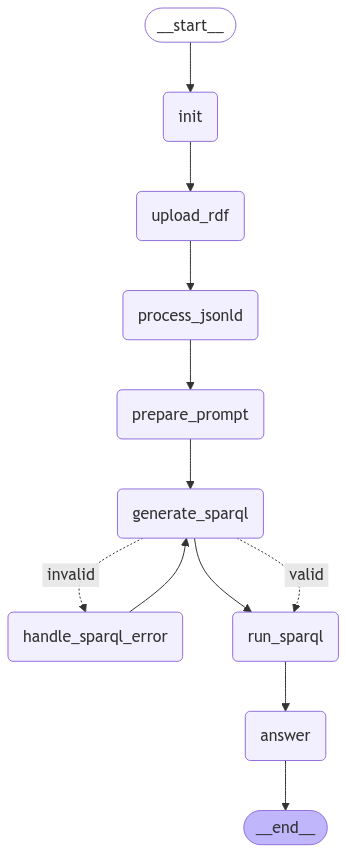

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass 
    